# Genetic Algorithms

The genetic algorithm is a probabilistic search algorithm that iteratively transforms a set (called a population) of mathematical objects (typically fixed-length binary character strings), each with an associated fitness value, into a new population of offspring objects using the Darwinian principle of natural selection and using operations that are patterned after naturally occurring genetic operations, such as crossover (sexual recombination) and mutation.)

In this section, we will demonstrate some basic implementations of Simple Genetic Algorithms (SGA), Real-valued GA, as well as the use of GA to generate permutations. At the end, we'll show how real-valued GA can be applied to a shortest-path search.

## Example: Bike pricing using Simple Genetic Algorithm
Assume that a company wants to design a new bicycle, and needs to consider the following costs:
- $700,000 for manufacturing setup, marketing, etc.
- $110 for each bike produced

Based on similar bikes, the company expects sales to follow this demand curve:

$Q= 70,000 - 200P$,<br>
where $P$ is the price, and $Q$ is the number of units sold at that price

For example:
- At $0, the company would give away 70,000 bikes for free
- At $300, the company would sell $70,000-200*300=10,000$ bikes
- At $350, the company wouldn't sell at anything at all.

Profit would be calculated as following:

$Profit=Sales-Costs$<br>
$Profit=P(70,000-200P)-(700,000+110(70,000-200P))$<br>
$Profit=-200P^2+92,000P-8,400,000$

### Implementation using SGA
Simple Genetic Algorithms represent genes as binary values, and mutates those genes through binary operations. Essentially, they replicate the behaviour of genotypes in genetics, where genotypes (actual DNA coding) produce phenotypes (genetic traits). 

In [21]:
import random
import math
from tqdm.notebook import tqdm

# SGA Parameters
num_gen = 30000
pop_size = 5
crossover_prob = 0.8
mutation_prob = 0.2
num_parents = 2

# Solution representation
chromosome_length = 9
best_score = -100000 # Initialize the "best solution"next

In [16]:
# Generate an initial random population
def init_pop(pop_size, chromosome_length):
    ints = [random.randint(0,350) for i in range(pop_size)]
    strs = [bin(n)[2:].zfill(chromosome_length) for n in ints]
    bins = [[int(x) for x in n] for n in strs]
    return bins

populations = init_pop(pop_size, chromosome_length)
parents=[]

In [17]:
def fitness_score():
    global populations, best_score
    fit_value = []
    num = []
    for i in range(len(populations)):
        num.append(int("".join(str(x) for x in populations[i]), base=2))  # convert binary to decimal
        fit_value.append(-200 * math.pow(num[i],2) + 92000 * num[i] - 8400000)
    fit_value, populations = zip(*sorted(zip(fit_value, populations), reverse=True))
    best_score = fit_value[0]
    return fit_value, best_score


This fitness function essentially determines how "good" a particular offspring is. It first converts each unit in the population to a binary number (the genotype), and then returns the "best" offspring.

In [18]:
# Random parent selection
def selectparent():
    global parents
    parents=random.sample(populations, num_parents)
    
    return parents

In [19]:
# Apply 1-point crossover
def crossover():  
    global parents
    if crossover_prob > random.random():
        cross_point = random.randint(0,chromosome_length)
        parents+= tuple([(parents[0][0:cross_point +1] +parents[1][cross_point+1:(chromosome_length+1)])])
        parents+= tuple([(parents[1][0:cross_point +1] +parents[0][cross_point+1:(chromosome_length+1)])])
    
    return parents

The crossover function here first determines if a crossover takes place (using the `crossover_prob`) and then selects a random crossover point in the chromosome. Using 1-point crossover, the bottom halves are switched the parents.

In [20]:
# Apply mutation

# Alter each gene independently with a probability mutation_prob
def mutation() :
    global populations, parents
  
    for i in range(len(parents)) :
        for j in range(chromosome_length) :
            if mutation_prob > random.random():
                if parents[i][j]==1:
                    parents[i][j]=0
                else:
                    parents[i][j]=1
                    
                populations = parents
    
    return populations

In [31]:
# The actual SGA is rather simple
scores = [] # track the best_scores across generations for visualization
for generations in tqdm(range(num_gen), total=num_gen):
    fitness_score()
    selectparent()
    crossover()
    mutation()
    scores.append(best_score)
    
fitness_score() # Generate the fitness scores again, as the last operation was a mutation
print("Best score:", best_score)
print("Best solution", int(''.join(str(x) for x in populations[0]), base=2))

  0%|          | 0/30000 [00:00<?, ?it/s]

Best score: 1775000.0
Best solution 185


## Example: Bike pricing using Real-value Genetic Algorithm
We can also run the above example using real-values instead. For this example, we'll use a solver to handle the population generation, mutation, and child creation.

In [34]:
import numpy as np
from ypstruct import structure
import math
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [35]:
# run Genetic Algorithm
def run(problem, params):
    
    # Problem Information
    costfunc = problem.costfunc
    nvar = problem.nvar
    varmin = problem.varmin
    varmax = problem.varmax

    # Parameters
    maxit = params.maxit
    npop = params.npop
    beta = params.beta
    pc = params.pc
    nc = int(np.round(pc*npop/2)*2)
    gamma = params.gamma
    mu = params.mu
    sigma = params.sigma

    # Empty Individual Template
    empty_individual = structure()
    empty_individual.position = None
    empty_individual.cost = None

    # Best Solution Ever Found
    bestsol = empty_individual.deepcopy()
    bestsol.cost = np.inf

    # Initialize Population
    pop = empty_individual.repeat(npop)
    for i in range(npop):
        pop[i].position = np.random.uniform(varmin, varmax, nvar)
        pop[i].cost = costfunc(pop[i].position)
        if pop[i].cost < bestsol.cost:
            bestsol = pop[i].deepcopy()

    # Best Cost of Iterations
    bestcost = np.empty(maxit)
    
    # Main Loop
    for it in tqdm(range(maxit), total=maxit):

        costs = np.array([x.cost for x in pop])
        avg_cost = np.mean(costs)
        if avg_cost != 0:
            costs = costs/avg_cost
        probs = np.exp(-beta*costs)

        popc = []
        for _ in range(nc//2):

            # Select Parents
            #q = np.random.permutation(npop)
            #p1 = pop[q[0]]
            #p2 = pop[q[1]]

            # Perform Roulette Wheel Selection
            p1 = pop[roulette_wheel_selection(probs)]
            p2 = pop[roulette_wheel_selection(probs)]
            
            # Perform Crossover
            c1, c2 = crossover(p1, p2, gamma)

            # Perform Mutation
            c1 = mutate(c1, mu, sigma)
            c2 = mutate(c2, mu, sigma)

            # Apply Bounds
            apply_bound(c1, varmin, varmax)
            apply_bound(c2, varmin, varmax)

            # Evaluate First Offspring
            c1.cost = costfunc(c1.position)
            if c1.cost < bestsol.cost:
                bestsol = c1.deepcopy()

            # Evaluate Second Offspring
            c2.cost = costfunc(c2.position)
            if c2.cost < bestsol.cost:
                bestsol = c2.deepcopy()

            # Add Offsprings to popc
            popc.append(c1)
            popc.append(c2)
        

        # Merge, Sort and Select
        pop += popc
        pop = sorted(pop, key=lambda x: x.cost)
        pop = pop[0:npop]

        # Store Best Cost
        bestcost[it] = bestsol.cost

    # Output
    out = structure()
    out.pop = pop
    out.bestsol = bestsol
    print("Best solution: ", bestsol.position)
    out.bestcost = bestcost
    return out

In [36]:
# perform single-point crossover
def crossover(p1, p2, gamma=0.1):
    c1 = p1.deepcopy()
    c2 = p1.deepcopy()
    alpha = np.random.uniform(-gamma, 1+gamma, *c1.position.shape)
    c1.position = alpha*p1.position + (1-alpha)*p2.position
    c2.position = alpha*p2.position + (1-alpha)*p1.position
    return c1, c2

In [37]:
# apply mutation
def mutate(x, mu, sigma):
    y = x.deepcopy()
    flag = np.random.rand(*x.position.shape) <= mu
    ind = np.argwhere(flag)
    y.position[ind] += sigma*np.random.randn(*ind.shape)
    return y

In [38]:
# apply boundary constraints
def apply_bound(x, varmin, varmax):
    x.position = np.maximum(x.position, varmin)
    x.position = np.minimum(x.position, varmax)

In [39]:
# roulette wheel selection
def roulette_wheel_selection(p):
    c = np.cumsum(p)
    r = sum(p)*np.random.rand()
    ind = np.argwhere(r <= c)
    return ind[0][0]

In [40]:
# Fitness function
def bike_pricing(X):
    return 200*math.pow(X,2) - 92000*X + 8400000

In [41]:
# Problem Definition
problem = structure()
problem.costfunc = bike_pricing
problem.nvar = 1
problem.varmin = [50]
problem.varmax = [350]

# Solver GA Parameters
params = structure()
params.maxit = 30000
params.npop = 5
params.beta = 1
params.pc = 1
params.gamma = 0.1
params.mu = 0.01
params.sigma = 0.1

In [42]:
# Run GA
out = run(problem, params)

  0%|          | 0/30000 [00:00<?, ?it/s]

Best solution:  [229.99997036]


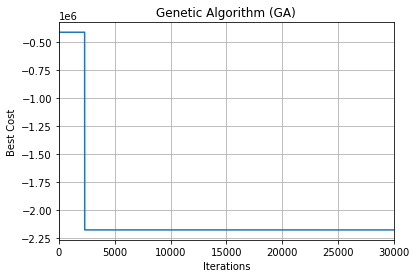

In [43]:
# Results
plt.plot(out.bestcost)
# plt.semilogy(out.bestcost)
plt.xlim(0, params.maxit)
plt.xlabel('Iterations')
plt.ylabel('Best Cost')
plt.title('Genetic Algorithm (GA)')
plt.grid(True)
plt.show()

## Example: Permutation Genetic Algorithm for TSP
As you know by now, the Travelling Salesman Problem is essentially about generating the least costly permutation of all vertices in a graph. Assuming the graph is fully connected (every permutation is feasible), we can consider the following set of operators:

### Crossover operators
1. Adjacency-based operators
    - Partially mapped crossover
    - Edge crossover
2. Order-based operators
    - Order 1 crossover
    - Cycle crossover

### Mutation Operators
1. Insert mutation
2. Swap mutation
3. Inversion mutation
4. Scramble mutation


In [47]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from smart_mobility_utilities.common import random_tour, cost_tour

Let's generate a random connected graph, so that any permutation of vertices is feasible.

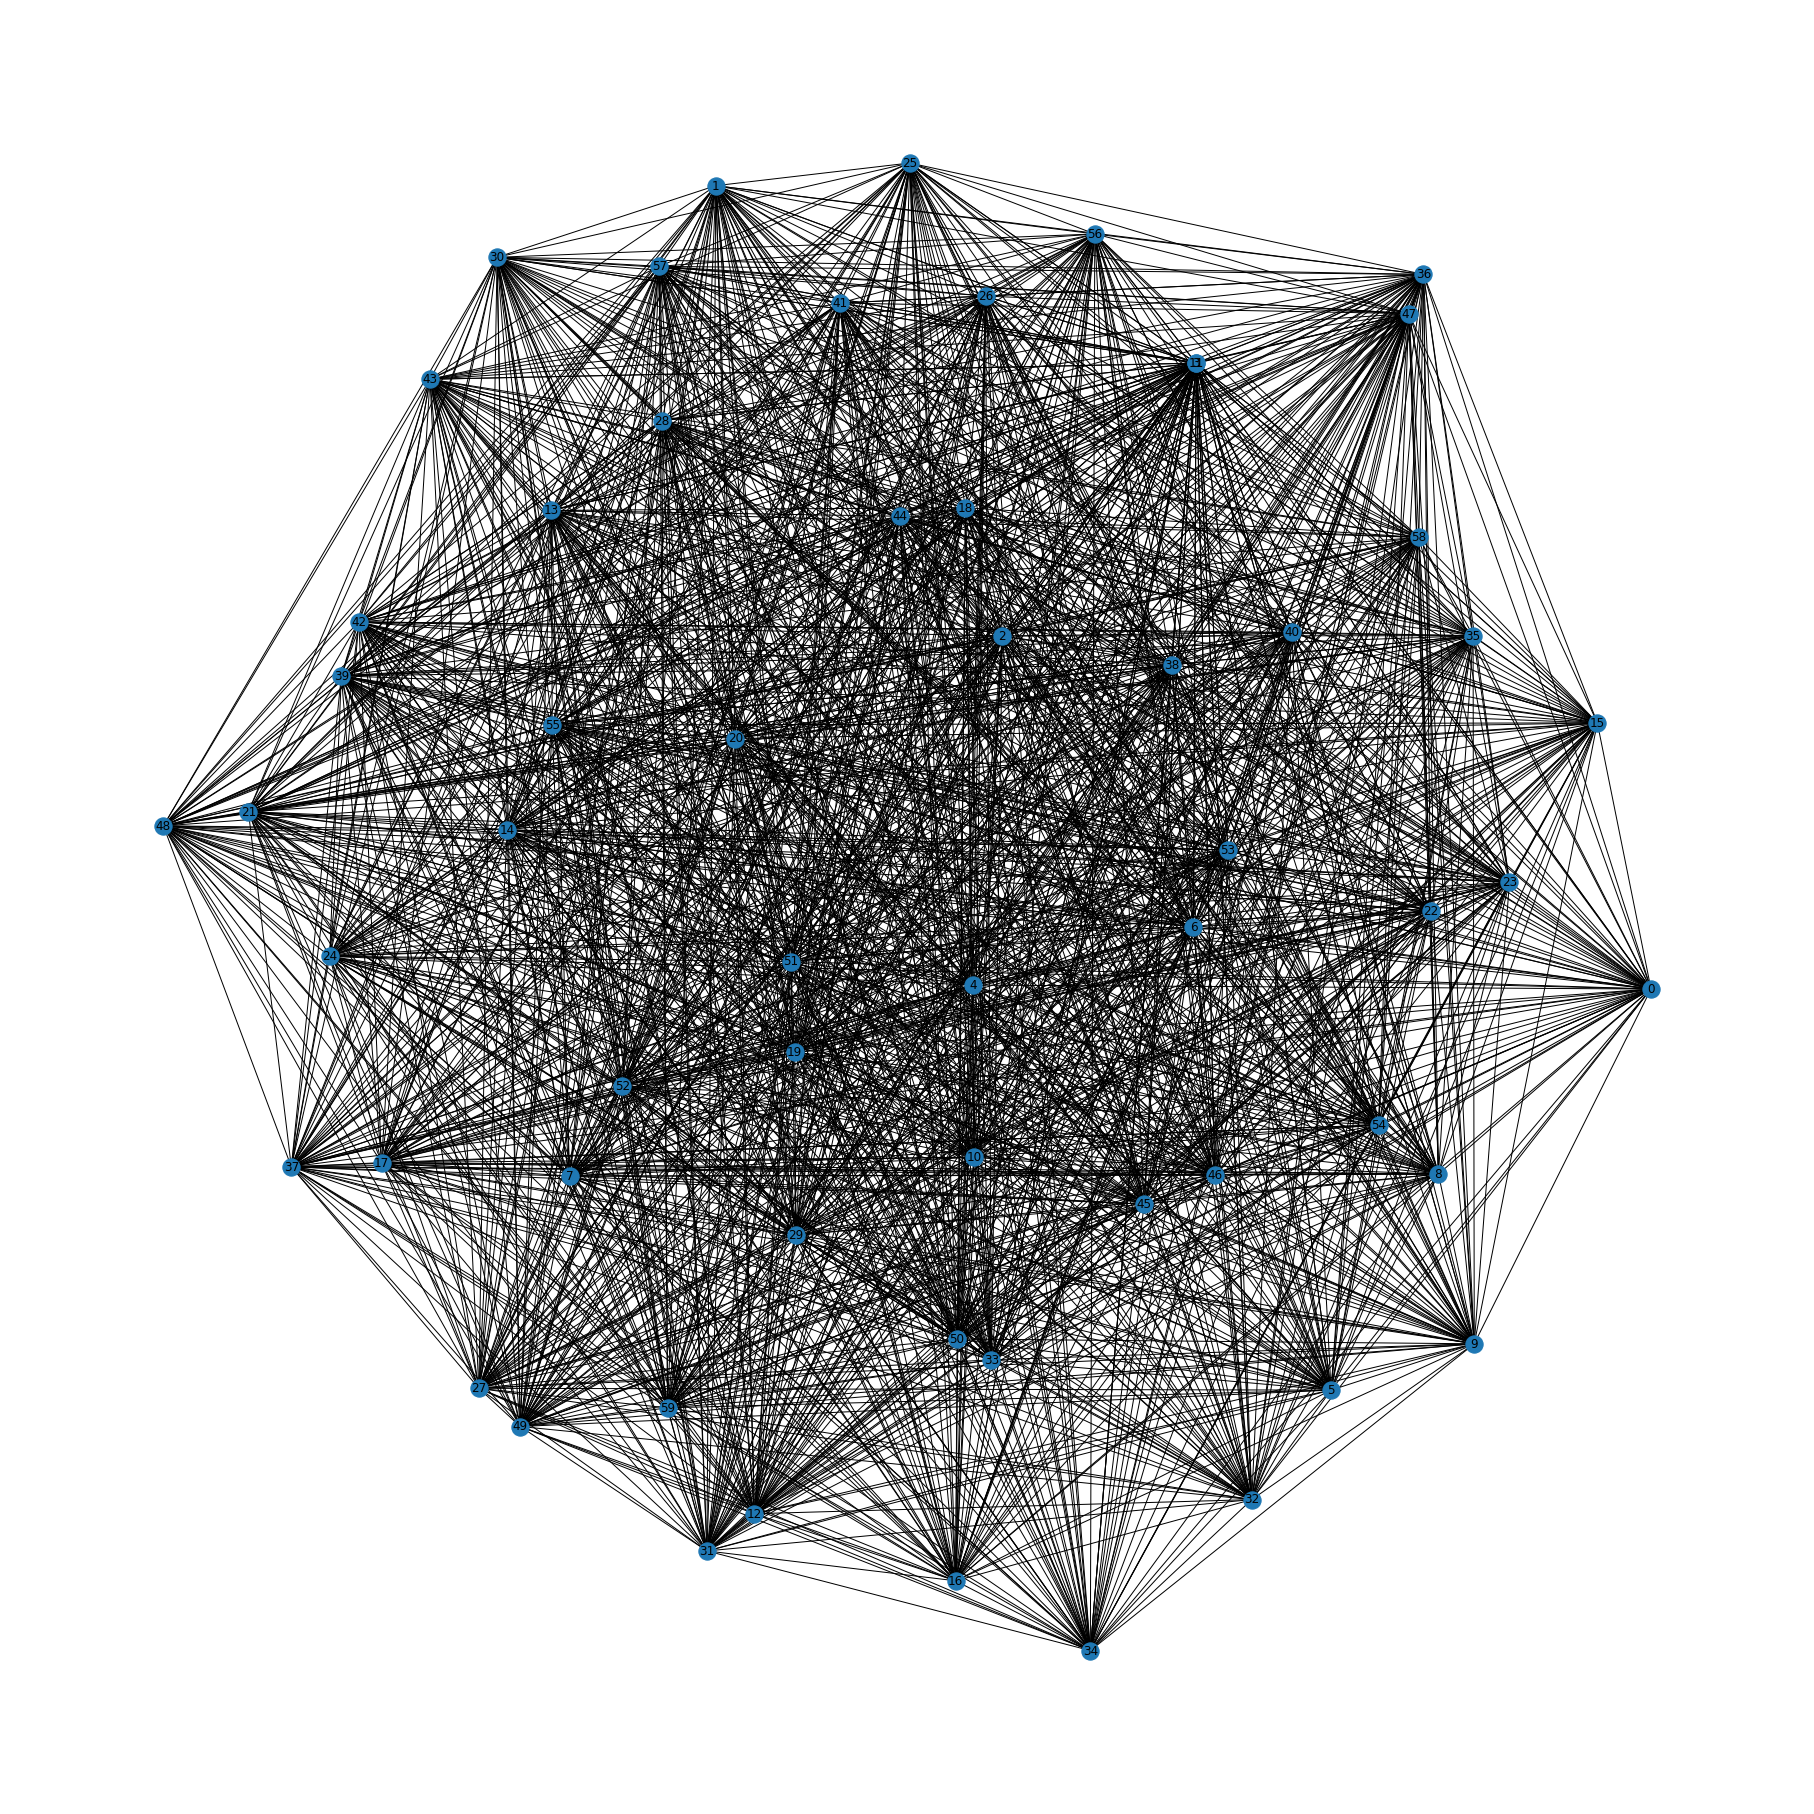

In [48]:
G = nx.complete_graph(60)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(0,40)

plt.figure(figsize=(25,25)) 
nx.draw(G, with_labels=True)
plt.show()

Let's assume we can generate two random tours of the graph, and we now want to generate another permutation from these two parents. We can't simply cut and paste or swap randomly, as that will likely generate a set that is not an actual and admissible permutation. For this reason, we need to consider the following crossover types that guarantee an acceptable permutation:

### Partially-mapped crossover
This algorithm is lightweight and disrupts a lot of the genes, which is a desirable effect for GA.

In [49]:
def PMX_crossover(firstPermutation, secondPermutation):
    # we need to know the length of either permutation
    # they must be equal in size
    length = len(firstPermutation)
    
    # (1) choosing the two crossover points
    #     by randomly select a point from the
    #     first half and another point from the second half
    first_Cross = random.randint(0, length // 2)
    second_Cross = random.randint(length // 2 + 1, length - 1) + 1
    
    # (2) initializing the two equal sized segments
    #     and create another array with the same size of 
    #     any permutation to be the child
    child = [None] * length
    subP1 = firstPermutation[first_Cross:second_Cross]
    subP2 = secondPermutation[first_Cross:second_Cross]
    
    # (3) copy the elements in the segment from the first permutation
    #    into the same segment in the child
    child[first_Cross:second_Cross] = subP1
    
    # (4) finding common elements in the segment from the
    #     the first permutation and the second permutation
    #     and get its mirror from first permutation to second
    pairs = list()
    for element in subP2:
        if element not in subP1:
            pairs.append((element, subP1[subP2.index(element)]))
    
    # (5) copying into the child all the elements in the segment
    #.    that are present in the first permutation segment but
    #.    aren't present in the second permutation segment.
    #.    if not we need to copy that element in place outside
    #     the segment in a place where we are sure that would
    #.    result into inadmissible permutations.
    for pair in pairs:
        second = pair[1]
        if second not in subP2:
            index = secondPermutation.index(second)
            child[index] = pair[0]
        else:
            # when there is an element from the segment of the first
            # permutation in the segment of the second permutation 
            reflect = firstPermutation[secondPermutation.index(second)]
            
            # bouncing back and forth between the two arrays indices
            # to get out of second permutation segment
            while reflect in subP2:
                bounce = reflect
                reflect = firstPermutation[secondPermutation.index(bounce)]
            child[secondPermutation.index(reflect)] = pair[0]
    
    # (6) go through all the elements that have not been assigned
    #     yet in the child array and assign them with the second permutation
    #     elements
    for i in range(length):
        if child[i] == None:
            child[i] = secondPermutation[i]
    return child

### Edge recombination crossover
The offspring of this crossover depends on the edges and connections between nodes in each permutation.

In [50]:
def ERO_crossover(G, firstPermutation, secondPermutation):
    # constructing edge table
    edgeTable = dict()
    elements = firstPermutation[:]
    length = len(elements)
    
    # just like adjacency list of nodes
    # in a given graph, but it is actually
    # the result of union between the two given
    # adjacency lists of a certain parent from both graphs
    for source in elements:
        edgeTable[source] = list()
        firstPermutationAdj = G[firstPermutation.index(source)]
        secondPermutationAdj = G[secondPermutation.index(source)]
        adjList = list(set().union(firstPermutationAdj, secondPermutationAdj))
        edgeTable[source]= adjList

    child = list()
    parent = random.choice(elements)
    elements.remove(parent)
    
    # terminate when the length of the child is the same
    # as the length of their parent
    while len(child) < length:
        child.append(parent)

        # remove the parent from all the adjacency lists
        for adjList in edgeTable.values():
            try:
                adjList.remove(parent)
            except:
                pass

        parentAdjList = edgeTable[parent][:]
        del edgeTable[parent]

        if len(parentAdjList) == 0: continue
        parent = min(parentAdjList, key = lambda parent : len(edgeTable[parent]))

    return child

### Order 1 crossover
This is much simpler crossover technique. It involves copying a random segement of nodes from the first parent, and completes the child with any nodes in the second parent not already present in the child.

In [51]:
def ordOne_crossover(firstPermutation, secondPermutation):
    length = len(firstPermutation)
    
    # choose the start and the end of the segment 
    # to be copied from the first parent
    start_Segment = random.randint(0, length // 2)
    end_Segment = random.randint(length // 2 + 1, length - 1) + 1
    
    # create a child
    child = list()
    
    # add the randomaly selected segment from the first parent
    child.extend(firstPermutation[start_Segment: end_Segment])
    
    # add what is left from the second parent that wasn't added from the first parent
    residueFromSegment = list(set(secondPermutation) - set(firstPermutation[start_Segment: end_Segment]))
    child.extend(residueFromSegment)
    
    return child

### Insert Mutation
This mutation selects two random genes and moves the second to follow the first directly. This ensures a valid permutation.

In [52]:
def insert_mutation(permutation):
    # copying the list so we don't mess with the original
    child = permutation[:]
    
    # choose two random genes and make sure that they are different
    first_gene = random.choice(child)
    second_gene = random.choice(child)
    while first_gene == second_gene:
        first_gene = random.choice(child)
        second_gene = random.choice(child)
    
    # removing the second gene from the list and insert it just after the first
    child.remove(second_gene)
    geneNewIndex = child.index(first_gene) + 1
    child.insert(geneNewIndex, second_gene)
    return child

### Swap Mutation
This mutation simply exchanges the positions of two nodes in a permutation.

In [53]:
def swap_mutation(permutation):
    # copying the list so we don't mess with the original
    child = permutation[:]

    length = range(len(child))

    # choose two random gene position so they could be swaped
    first_gene_pos, second_gene_pos = random.sample(length, 2)

    # swapping 
    child[first_gene_pos], child[second_gene_pos] =\
    child[second_gene_pos], child[first_gene_pos] 

    return child

### Implementation

For this example, we'll use Partially-mapped crossovers and Insert mutations, but others could be substituted as well.

In [62]:
# remember that ERO takes the graph as input
# not like PMX or Order 1
crossover = PMX_crossover
mutate = insert_mutation

size_of_population = 100
ngen = 500
best_at_gen = [] # for keeping track of the best tour at a given generation

# Initialize population
pool = [*random_tour(G.nodes, number_of_perms=size_of_population)]

In [63]:
for generation in tqdm(range(ngen)):
    # 1- crossover every consecutive pair of routes
    # 2- replace the weakest of the two parent with the product of the crossover
    # 3- mutate the whole pool
    # 4- repeat and save the value best tour in that generation
    
    # 1-
    for parent1, parent2 in zip(pool, pool[1:]):
        child = crossover(parent1, parent2)
        
        # 2-
        if cost_tour(G, parent1) > cost_tour(G, parent2):
            pool[pool.index(parent2)] = child
        else:
            pool[pool.index(parent1)] = child
    
    # 3-
    for i in range(size_of_population):
        pool[i] = mutate(pool[i])
    
    # 4-
    best_at_gen.append(cost_tour(G, min(pool, key = lambda tour : cost_tour(G, tour))))

  0%|          | 0/500 [00:00<?, ?it/s]

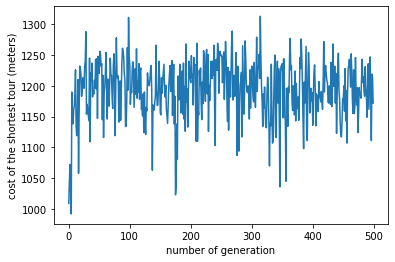

In [64]:
tour = min(pool, key = lambda route : cost_tour(G, route)) # result
tour_cost = cost_tour(G, tour) #result cost

plt.xlabel("number of generation")
plt.ylabel("cost of the shortest tour (meters)")
plt.plot(best_at_gen)
plt.show()

As you may notice, there is not much convergence in the costs of the tours in this GA implementation. This is largely because the solutions of the problem are very close to each other (there is only a limited range of edge weights).

## Example: Real-value Genetic Algorithm shortest path search
For the examples in this section, we will move past our University of Toronto search space in the previous section in favour of a more complex environment. This is the kind of network which really benefits from Genetic Search Algorithms.

Let's consider the road network in Vaughan, a municipality to the north of Toronto:

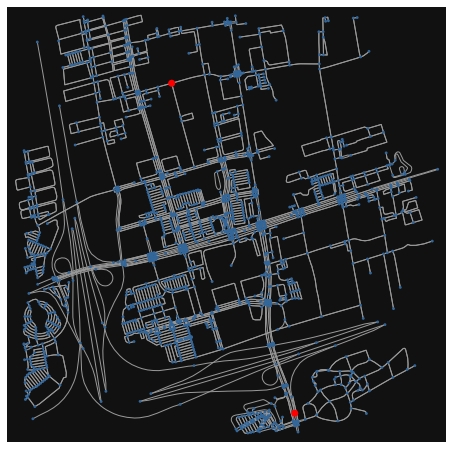

In [4]:
import osmnx

G = osmnx.graph_from_address('vaughan', dist=1400)

origin = 29658954
destination = 701446851

highlighted = [origin, destination]

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

For this example, we'll be attempting to search for the shortest route between two points highlighted in red.

### The Algorithm

There are many ways to design a genetic algorithm; the below is only one of them.

1. We will need a fitness function to determine which offspring to keep in each generation. This will be the length of the route generated (we want to minimize this).
2. As we will be doing a real-value (non-binary) GA, out phenotype is the same as our genotype.
3. Our GA implementation is "kind of" steady state: we probabilistically choose the best routes to be the parents of the next generation. More on this later.
4. We will be doing [1-point crossover](https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)#One-point_crossover).
5. Route mutations take place by deleting a random number of genes/nodes and trying to stitch that gap. Keep in mind this is time-intensive.
6. Selection is based on fitness-proportionate criteria.

The actual algorithm (in pseudo-code) looks like this:

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>GENETIC_ALGORITHM</b>(<i>source</i>,<i>destination</i>, <i>num_of_generations</i>. <i>pool_size</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">pool</font></i> &larr; <span>random-routes between <i>source</i> and <i>destination</i></span><br><br>
        for <i>num_of_generations</i> do<br>
        <div style='padding-left:20px;'>
            <i><font color="orange">parents_first_gen</font></i> &larr; <span>select number of best routes from <i><font color="green">pool</font></i></span><br>
            <i><font color="blue">parents_second_gen</font></i> &larr; <span>crossover <i><font color="orange">parents_first_gen</font></i></span><br>
            <i><font color="purple">parents</font></i> &larr; <span>mutate <i><font color="blue">parents_second_gen</font></i></span><br>
            <i><font color="green">pool</font></i> &larr; <span>offspring of <i><font color="purple">parents</font></i></span><br>
            remove duplicates from <i><font color="green">pool</font></i> and add random routes to compensate any removal<br>
        </div>
        endfor<br>
        <i>route</i> &larr; best <i>route</i> in <i><font color="green">pool</font></i><br>
        return <i>route</i>
    </div>
</div>

#### Mutation
Our algorithm "mutates" a child (route) by deleting a node between two nodes in the child, and attempting to fill in the gap with alternate nodes. If you recall the way we generated "children" for Beam Search and Hill climbing in previous sections, this uses the same idea.

In [1]:
from smart_mobility_utilities.children import shortest_path_with_failed_nodes_single
import random
import math

def mutate(G, route):
    source = route[0]
    destination = route[len(route) - 1]

    failed = random.choice(route)

    path = shortest_path_with_failed_nodes_single(G, route, [failed])

    # This method could fail because of a lot of factors relating to the graph structure
    # Check the documentation fo the shortest_path_with_failed_nodes to learn more
    while path == math.inf:
        failed = random.choice(route)
        path = shortest_path_with_failed_nodes_single(G, route, [failed])
    
    return path

#### Crossover
Rather than selecting a random point to "crossover", we look for a common node between the two routes.

In [2]:
import itertools
from smart_mobility_utilities.common import probability

def cross_over(route_1, route_2):
    origin = route_1[0]
    destination = route_1[len(route_1) - 1]

    intersection = [*itertools.filterfalse(\
                    lambda element : element in [origin, destination] ,\
                    list(set(route_1) & set(route_2)))]
    
    if len(intersection) == 0: return route_1 # if there is not common node, just return the first route

    cross_over_point = random.choice(intersection)
    first_point = route_1.index(cross_over_point)
    second_point = route_2.index(cross_over_point)

    if probability(0.5):
        return route_1[:first_point] + route_2[second_point:]
    else:
        return route_2[:second_point] + route_1[first_point:]

#### Offspring
The method for generating offspring is similar to that of mutation, but rather than choosing a random node for mutation, we choose nodes in order starting from the second in the route, up to the second-to-last. This limitation is caused by that fact that we cannot remove either the source or destination nodes.

#### Duplicates
Our offspring will likely result in many duplicates, as most routes will closely ressemble each other. To account for this, we remove any duplicates and replace them with new randomly generated routes. This also ensures population diversity.

### The code

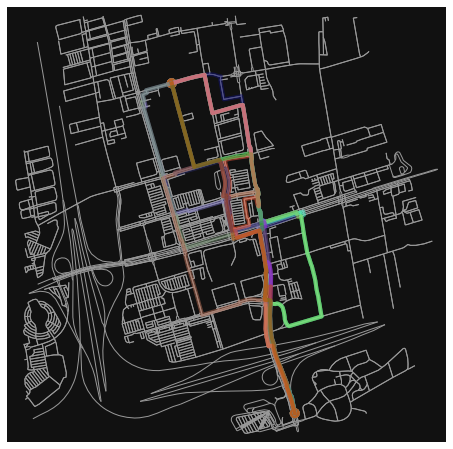

In [5]:
from smart_mobility_utilities.common import randomized_search

# Configure some parameters
n_gen = 20 # Anything above 20 will take some time but yield much better results
pool_size = 15 # Number of routes in each generation
parents_num = 3 # Needs to be a factor of pool_size

# Initialize the pool
pool = [randomized_search(G,origin,destination) for _ in range(pool_size)]

# Plot the pool on a map
random_hexa = lambda: random.randint(0,255) # generate random hexadecimal color
rc = ['#%02X%02X%02X' % (random_hexa(),random_hexa(),random_hexa()) for _ in range(pool_size)]
fig, ax = osmnx.plot_graph_routes(G, pool, route_colors=rc, route_linewidth=6, node_size=0)

The following code will take quite a bit of time to run.

In [6]:
from tqdm.notebook import tqdm
from smart_mobility_utilities.common import cost, flatten
from smart_mobility_utilities.children import get_children
import heapq

# A function to randomly select the initial parents
def select_best(pool, num_of_choices, probability_dist):
        return random.choices(population=pool, weights=probability_dist, k= num_of_choices)


states = []

for gen in tqdm(range(n_gen)):
    weights = [cost(G,route) for route in pool]
    parents_1 = select_best(pool, parents_num, weights)

    # Crossover every pair in parents, this means nP2 routes
    parents_2 = [cross_over(route_1,route_2) for route_1,route_2 in itertools.product(parents_1, repeat=2)]
    # Select the best
    parents_2 = heapq.nsmallest(parents_num, parents_2, key=lambda route: cost(G,route))

    # Mutate the parents
    parents = [mutate(G,route) for route in parents_2]

    # Generate the offspring for each parent -- each parent generates pool_size/parents_num children
    pool = flatten([get_children(G,route,num_children=pool_size//parents_num) for route in parents])

    # Remove duplicates
    pool = [*map(list, list(set(map(tuple,pool))))]
    num_removed = pool_size - len(pool) + 1
    # Replace the removed ones
    pool.extend([randomized_search(G,origin,destination) for _ in range(num_removed)])

    # Track the costs at each generation
    states.append(cost(G, min(pool, key = lambda route : cost(G, route))))

# Retrieve the final best route
route = min(pool, key=lambda route: cost(G,route))

  0%|          | 0/20 [00:00<?, ?it/s]

Cost of the route: 2800.424


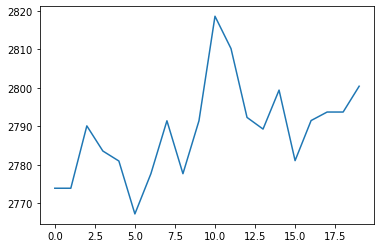

In [7]:
from smart_mobility_utilities.viz import draw_route
import matplotlib.pyplot as plt
print("Cost of the route:",cost(G,route))
ax = plt.plot(states)

In [8]:
draw_route(G,route, zoom=13)

Map(center=[43.7907708, -79.5414667], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…